# Retraining YOLO for Screen Time Detection

## Create Training/Testing Set 

In [51]:
import glob as glob
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    roc_auc_score,
)

import image_processor
import utils


### Get Classes and Manually Labelled Data
We use the classes that we have used in the manual labelling as our target set of classes.

In [2]:
# TODO
# Wrangle labelled data

### Get Pre-Labelled Data for Relevant Classes
We can supplement our training data using the COCO dataset for classes that are in our target classes. If the model is still weak in some areas, we can try supplementing this with more pre-labelled datasets.

### COCO

In [52]:
# TODO
# Check if COCO data is already downloaded. If not, download the labels and images that we want.
useful_labels = [
    "bottle",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "dining table",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "cup",
]
coco_folder = "/Users/tasanders/Documents/coco"
class_file = "/Users/tasanders/GitHub/labelImg/data/predefined_classes.txt"
coco_labels = "/Users/tasanders/Documents/coco/labels"
snapit_labels = (
    "/Volumes/M&B/Screen_Time_Measure_Development/SNAP_IT/YOLO_Training/Labelled_Data"
)

open_labels = "/Users/tasanders/Documents/openimages/labels"
oi_folder = "/Users/tasanders/Documents/openimages"

In [4]:
utils.download_coco_subset(
    folder=coco_folder,
    labels=useful_labels,
    parallel=True,
    class_file=class_file,
)

Finding meta-data
Making folders
Getting coco data
Working on instances_val2017.json
loading annotations into memory...


100%|██████████| 1756/1756 [00:00<00:00, 355617.68it/s]

Done (t=0.75s)
creating index...
index created!
Working on instances_train2017.json
loading annotations into memory...


Done (t=12.42s)
creating index...
index created!


100%|██████████| 40545/40545 [00:01<00:00, 31309.65it/s]


### Open Images

In [4]:
oi_labels = {
    "Apple": "apple",
    "Bagel": "bagel",
    "Baked goods": "baked goods",
    "Banana": "banana",
    "Bell pepper": "bell pepper",
    "Bottle": "bottle",
    "Bowl": "bowl",
    "Bread": "bread",
    "Broccoli": "broccoli",
    "Burrito": "burrito",
    "Cabbage": "cabbage",
    "Cake": "cake",
    "Cantaloupe": "cantaloupe",
    "Carrot": "carrot",
    "Coconut": "coconut",
    "Coffee": "coffee",
    "Coffee cup": "coffee cup",
    "Computer keyboard": "keyboard",
    "Computer monitor": "computer monitor",
    "Computer mouse": "mouse",
    "Cookie": "biscuit",
    "Cream": "cream",
    "Croissant": "croissant",
    "Cucumber": "cucumber",
    "Cutting board": "cutting board",
    "Dairy": "dairy",
    "Dessert": "dessert",
    "Doughnut": "donut",
    "Drink": "drink",
    "Egg": "egg",
    "Fast food": "fast food",
    "Food": "food",
    "Fork": "fork",
    "French fries": "french fries",
    "Fruit": "fruit",
    "Hamburger": "hamburger",
    "Hot dog": "hot dog",
    "Ice cream": "ice cream",
    "Ipod": "ipod",
    "Jug": "jug",
    "Juice": "juice",
    "Kitchen & dining room table": "dining table",
    "Kitchen knife": "kitchen knife",
    "Kitchen utensil": "kitchen utensil",
    "Knife": "knife",
    "Laptop": "laptop",
    "Mango": "mango",
    "Microwave oven": "microwave",
    "Milk": "milk",
    "Mobile phone": "cell phone",
    "Muffin": "muffin",
    "Mug": "mug",
    "Mushroom": "mushroom",
    "Orange": "orange",
    "Oven": "oven",
    "Pancake": "pancake",
    "Pasta": "pasta",
    "Pastry": "pastry",
    "Peach": "peach",
    "Pear": "pear",
    "Pen": "pen",
    "Pineapple": "pineapple",
    "Pitcher": "pitcher",
    "Pizza": "pizza",
    "Plate": "plate",
    "Pomegranate": "pomegranate",
    "Popcorn": "popcorn",
    "Potato": "potato",
    "Pretzel": "pretzel",
    "Pumpkin": "pumpkin",
    "Radish": "radish",
    "Refrigerator": "refrigerator",
    "Remote control": "remote",
    "Salad": "salad",
    "Sandwich": "sandwich",
    "Seafood": "seafood",
    "Shrimp": "shrimp",
    "Sink": "sink",
    "Snack": "snack",
    "Spoon": "spoon",
    "Strawberry": "strawberry",
    "Submarine sandwich": "submarine sandwich",
    "Sushi": "sushi",
    "Tablet computer": "tablet",
    "Taco": "taco",
    "Tart": "tart",
    "Tea": "tea",
    "Television": "tv",
    "Toaster": "toaster",
    "Tomato": "tomato",
    "Vegetable": "vegetable",
    "Waffle": "waffle",
    "Watermelon": "watermelon",
    "Zucchini": "zucchini",
}


In [35]:
utils.download_openimages_subset(
    folder=oi_folder, labels_dict=oi_labels, parallel=True, class_file=class_file,core_only=True
)

Making folders
getting images (140710)


100%|██████████| 140710/140710 [00:02<00:00, 58945.14it/s]


### Data Summary

In [3]:
df = utils.count_instances([coco_labels, snapit_labels, open_labels],class_file,parallel=True)

100%|██████████| 103525/103525 [01:10<00:00, 1464.88it/s]


In [5]:
df

,label,objects,images
0,book open,34.0,34.0
1,cell phone,13159.0,9803.0
2,refrigerator,3436.0,3091.0
3,microwave,2271.0,2094.0
4,oven,4166.0,3566.0
5,bottle,63503.0,20448.0
6,fork,7459.0,4851.0
7,knife,9205.0,5314.0
8,spoon,8123.0,4772.0
9,glass,63.0,52.0


<AxesSubplot:xlabel='label'>

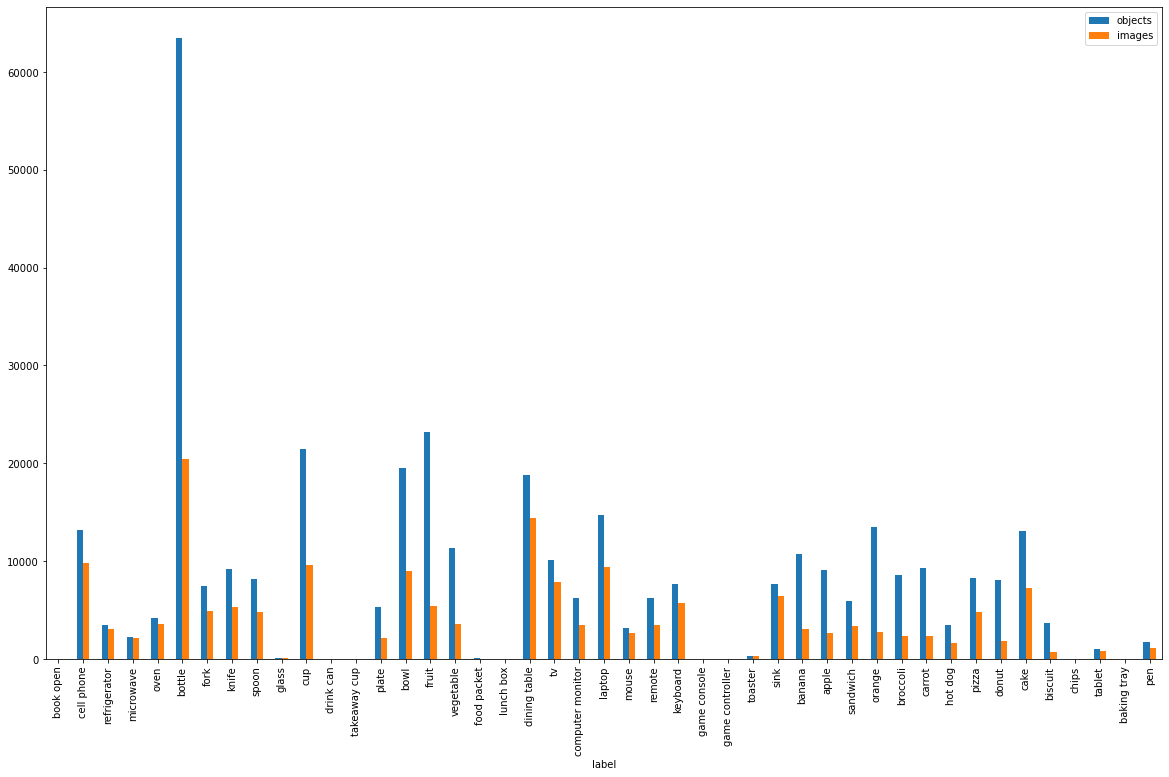

In [4]:
df.plot(kind="bar", x="label",figsize=(20,12))

In [180]:
# TODO
# Combine the manually labelled and the COCO datasets
importlib.reload(utils)

<module 'utils' from '/Users/tasanders/GitHub/SquareEyes/notebooks/utils.py'>

In [181]:
df = utils.prep_dataset(
    class_file=class_file,
    coco_labels_folder=coco_labels,
    snapit_labels_folder=snapit_labels,
    oi_labels_folder=open_labels,
)

100%|██████████| 60372/60372 [00:08<00:00, 7161.14it/s]


In [207]:
class_nums = list(reversed(df["class_id"].value_counts().index))

In [208]:
class_nums

[8,
 21,
 34,
 35,
 2,
 18,
 1,
 29,
 33,
 3,
 10,
 25,
 19,
 16,
 5,
 22,
 20,
 31,
 7,
 30,
 27,
 24,
 6,
 28,
 15,
 23,
 13,
 32,
 0,
 26,
 17,
 14,
 11,
 9,
 12,
 4]

In [222]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

In [224]:
sss = StratifiedShuffleSplit(1, test_size=0.25, random_state=0)

In [225]:
sss.get_n_splits(df["file"])

1

In [229]:
for train_index, test_index in sss.split(df["class_id"],df["class_id"]):
    print(train_index)

[124386 157937 292612 ...  39486  31580 199228]


In [202]:
df["set"] = np.NaN

In [215]:
df.reset_index(inplace=True, drop=True)

In [231]:
df_idx = df.loc[(df["class_id"] == class_nums[0])&(df["set"].isna())].index

In [235]:
df[df["source"]=="snapit"]["class_id"].value_counts()

0     390
15    224
8      63
14     57
34     57
20     31
11     24
10     19
22     15
6      14
19     12
1      11
4      10
3      10
7       9
27      8
2       7
12      7
18      7
5       3
17      3
33      3
21      2
35      2
9       1
Name: class_id, dtype: int64

In [189]:
df["class_id"].value_counts().index

Int64Index([ 4, 12,  9, 11, 14, 17, 26,  0, 32, 13, 23, 15, 28,  6, 24, 27, 30,
             7, 31, 20, 22,  5, 16, 19, 25, 10,  3, 33, 29,  1, 18,  2, 35, 34,
            21,  8],
           dtype='int64')

In [130]:
df_valcnt = df["class_id"].value_counts()
df_valcnt = sorted(list(df_valcnt[df_valcnt<100].index),reverse=True)

In [133]:
with open(class_file, "r") as f:
    classes = f.read().split("\n")

In [178]:
test_list = list("ABCDEFHIJK")
for x in range(len(test_list)-1,-1,-1):
    del test_list[x]
    print(x)

9
8
7
6
5
4
3
2
1
0


In [179]:
test_list

[]

In [167]:
for i in range(len(classes)-1,-1,-1):
    print(i)

43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [153]:
sorted(df["class_id"].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42]

In [151]:
df["class_id"] = df["class_id"].apply(lambda x: x-1 if x>df_valcnt[4] else x)

### Create Training Split
We could normally just define a random split. But, we want to avoid a couple of potential issues. So, our training split should be random but follow some rules:
1. COCO images should be training and testing only, but shouldn't be included in the validation set.
2. Similiarly, if a participant is in the training set, they should not be in the validation set. Many images end up being far too similar, and we risk not really understanding how the model will perform on 'unseen' data.

In [ ]:
# TODO
# Create training/testing/validation sets

## Retrain the Model

In [ ]:
# TODO
# Retrain model and save new model weights

## Evaluate the Model

In [ ]:
# TODO
# Evaluate the model on labelled data.